# DonkeyCarAugmentator

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm
import json
from PIL import Image
import base64
from io import BytesIO
import inspect
import matplotlib.pyplot as plt

## Load data

In [ ]:
TIME=str(time())

STORAGE_ROOT_DIR = "drive/My Drive/ColabStorage/DonkeyCar/Simulator"
TRAINER_PROJECT_PATH = "Trainer"

DATASET_NAME = "corentin_renault_25829_rc_thr0.5"
DATASET_PATH = DATASET_NAME
DATASET_LABEL_FILENAME = "label.csv"
DATASET_LABEL_PATH = os.path.join(DATASET_PATH, DATASET_LABEL_FILENAME)

IMAGE_SHAPE = (120,160, 3)
print("Ok.")

Ok.


In [ ]:
!rm -Rf "corentin_renault_25829_rc_thr0.5"
!cp "drive/My Drive/ColabStorage/DonkeyCar/Simulator/Dataset/corentin_renault_25829_rc_thr0.5.eslr" "corentin_renault_25829_rc_thr0.5.eslr"

In [ ]:
DATASET_JSON_FILE = DATASET_PATH + ".eslr"

IMAGE_PATH = "images"
DATASET_IMAGE_PATH = os.path.join(DATASET_PATH, IMAGE_PATH)

if not os.path.exists(DATASET_PATH):
    os.mkdir(DATASET_PATH)
if not os.path.exists(DATASET_IMAGE_PATH):
    os.mkdir(DATASET_IMAGE_PATH)

In [ ]:
DATA_LABEL_FILE = open(DATASET_LABEL_PATH, "w")
DATA_LABEL_FILE.write("path,angle,throttle,speed\n")#XXX
with open(DATASET_JSON_FILE, "r") as dataset_file:
    for i, line in enumerate(tqdm(dataset_file)):
        data_line = json.loads(line)
        if (data_line["msg_type"] == "telemetry"):
            image_relative_path = os.path.join(IMAGE_PATH, str(i)+".jpeg") #XXX
            image_absolute_path = os.path.join(DATASET_PATH, image_relative_path)
            Image.open(BytesIO(base64.b64decode(data_line["image"]))).save(image_absolute_path)
            # Toutes les données à ajouter dans la dataset
            data2write = [image_relative_path, str(data_line["user_angle"]), str(data_line["user_throttle"]), str(data_line["speed"])]#XXX
            DATA_LABEL_FILE.write(",".join(data2write) + "\n")
DATA_LABEL_FILE.close()
print("ok.")

25829it [00:42, 606.32it/s]

ok.


In [ ]:
# Obetnir les valeurs du fichier contenant les labels
raw_data = pd.read_csv(DATASET_LABEL_PATH)

# change la chemin de fichier
def change_path(path):
  return os.path.join(DATASET_PATH, path)
raw_data['path'] = raw_data['path'].map(change_path)
print(raw_data)

                                                    path  ...     speed
0         corentin_renault_25829_rc_thr0.5/images/0.jpeg  ...  8.828243
1         corentin_renault_25829_rc_thr0.5/images/1.jpeg  ...  8.725200
2         corentin_renault_25829_rc_thr0.5/images/2.jpeg  ...  8.613990
3         corentin_renault_25829_rc_thr0.5/images/3.jpeg  ...  8.469450
4         corentin_renault_25829_rc_thr0.5/images/4.jpeg  ...  8.386406
...                                                  ...  ...       ...
25824  corentin_renault_25829_rc_thr0.5/images/25824....  ...  8.067424
25825  corentin_renault_25829_rc_thr0.5/images/25825....  ...  8.015923
25826  corentin_renault_25829_rc_thr0.5/images/25826....  ...  7.756970
25827  corentin_renault_25829_rc_thr0.5/images/25827....  ...  7.689636
25828  corentin_renault_25829_rc_thr0.5/images/25828....  ...  7.731779

[25829 rows x 4 columns]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6e3eb0190>,
      dtype=object)

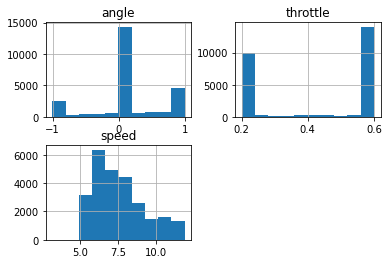

In [ ]:
raw_data.hist()

## Pick and transform image

### Read one image with Tensorflow (and plt.imshow)

In [ ]:
img_path = raw_data.iloc[42]['path']

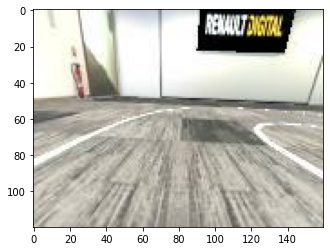

In [ ]:
tf_img = tf.io.read_file(img_path)
tf_img = tf.io.decode_jpeg(tf_img)
plt.imshow(tf_img)

### Read a set of images with Tensorflow

#### Pick randomly 9 images

In [ ]:
number_image_path_list = [42 * i for i in range(9)]
image_path_list = raw_data.iloc[number_image_path_list]['path']

In [ ]:
image_path_list_tf = tf.data.Dataset.from_tensor_slices(image_path_list)

In [ ]:
image_list_tf = image_path_list_tf.map(lambda filename: tf.cast(tf.io.decode_jpeg(tf.io.read_file(filename)), tf.float32))
image_list_tf

<MapDataset shapes: (None, None, None), types: tf.float32>

## Transforme a set of images

In [ ]:
## Ré-initialiser TRANSFORMED IMAGES
transformed_image_list_tf = tf.identity(image_list_tf)

In [ ]:
def clip_image(img):
  return tf.clip_by_value(img, clip_value_min=0, clip_value_max=255)

## Ajusted

### Brightness


In [ ]:
# -100 to 50
transformed_image_list_tf = image_list_tf.map(lambda img: clip_image(tf.image.adjust_brightness(img, 50)))

### Contrast


In [ ]:
# 0.5 to 1.5
transformed_image_list_tf = image_list_tf.map(lambda img: clip_image(tf.image.adjust_contrast(img, 0.5)))

### Gamma


In [ ]:
# normal : gamme = 1, gain = 1
# 0.97 <= gamma <= 1.03 // 0.92 <= gain <= 1.08
transformed_image_list_tf = image_list_tf.map(lambda img: clip_image(tf.image.adjust_gamma(img, gamma=1.03, gain=1.08)))

### Hue


In [ ]:
transformed_image_list_tf = image_list_tf.map(lambda img: clip_image(tf.image.adjust_hue(img, -0.5)))

### Jpeg Quality (does not work)


In [ ]:
# Does not work
transformed_image_list_tf = image_list_tf.map(lambda img: clip_image(tf.image.adjust_jpeg_quality(img, 100)))

### Saturation


In [ ]:
# 0.5 to 2.5
transformed_image_list_tf = image_list_tf.map(lambda img: clip_image(tf.image.adjust_saturation(img, 2.5)))

### Random Noise

In [ ]:
# mean = 0
# stddev = 0.5
mean = 0
stddev = 0.5
def normalize(img):
  return (img / 127.5) - 1.0

def unnormalize(img):
  return (img + 1.0) * 127.5

transformed_image_list_tf = image_list_tf.map(lambda img: clip_image(unnormalize(tf.add(normalize(img), tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev)))))

## Random

In [ ]:
class DonkeyCarDataAugmentator:
  @staticmethod
  def normalize(img):
    return (img / 127.5) - 1.0
  
  @staticmethod
  def unnormalize(img):
    return (img + 1.0) * 127.5

  @staticmethod
  def clip_image(img):
    return tf.clip_by_value(img, clip_value_min=0, clip_value_max=255)

  @staticmethod
  def noiser(img, mean, stddev):
    transformed_img = DonkeyCarDataAugmentator.normalize(img)
    noise_img = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev)
    transformed_img = tf.add(transformed_img, noise_img)
    transformed_img = DonkeyCarDataAugmentator.unnormalize(transformed_img)
    transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)
    return transformed_img

  @staticmethod
  def transform(img, angle, ratio_augmentation = 0.75, ratio_flip_left_right = 0.5, max_brightness = 50,
                lower_contrast = 0.75, upper_contrast = 1.5, lower_saturation = 0.0, 
                upper_saturation = 2, mean_noise = 0.0, max_noise = 0.3):
    
    random_do_augmentation = tf.random.uniform(shape=[], minval = 0., maxval = 1., dtype=tf.float32)
    if random_do_augmentation <= ratio_augmentation:
      transformed_img = tf.image.random_brightness(img, max_delta = max_brightness)
      transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)

      transformed_img = tf.image.random_contrast(transformed_img, lower = lower_contrast, upper = upper_contrast)
      transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)
      
      transformed_img = tf.image.random_saturation(transformed_img, lower = lower_saturation, upper = upper_saturation)
      transformed_img = DonkeyCarDataAugmentator.clip_image(transformed_img)

      random_noise_gain = tf.random.uniform(shape=[], minval = 0.0, maxval = max_noise, dtype=tf.float32)
      transformed_img = DonkeyCarDataAugmentator.noiser(transformed_img, mean_noise, random_noise_gain)
    else:
      transformed_img = img
    
    random_do_flip = tf.random.uniform(shape=[], minval = 0., maxval = 1., dtype=tf.float32)
    if random_do_flip <= ratio_flip_left_right:
      transformed_img = tf.image.flip_left_right(transformed_img)
      angle *= -1
    
    return transformed_img, angle


In [ ]:
transformed_image_list_tf = image_list_tf.map(lambda img: DonkeyCarDataAugmentator.transform(img, 0)[0])

In [ ]:
raw_data['path']

0           corentin_renault_25829_rc_thr0.5/images/0.jpeg
1           corentin_renault_25829_rc_thr0.5/images/1.jpeg
2           corentin_renault_25829_rc_thr0.5/images/2.jpeg
3           corentin_renault_25829_rc_thr0.5/images/3.jpeg
4           corentin_renault_25829_rc_thr0.5/images/4.jpeg
                               ...                        
25824    corentin_renault_25829_rc_thr0.5/images/25824....
25825    corentin_renault_25829_rc_thr0.5/images/25825....
25826    corentin_renault_25829_rc_thr0.5/images/25826....
25827    corentin_renault_25829_rc_thr0.5/images/25827....
25828    corentin_renault_25829_rc_thr0.5/images/25828....
Name: path, Length: 25829, dtype: object

In [ ]:
train_tensor = tf.data.Dataset.from_tensor_slices(({"input" : raw_data['path'], "speed" : raw_data['speed']}, {"angle" : raw_data['angle']}))

In [ ]:
# Definir les fonctions de chargement des images et de mapping
def load_and_preprocess_image(input_dict):
    file_content = tf.io.read_file(input_dict['input'])
    tricolors_img = tf.cast(tf.image.decode_jpeg(file_content, channels=3), dtype=tf.float32) #XXX
    #gray_img = tf.image.rgb_to_grayscale(tricolors_img) #XXX
    normalized_img = (tricolors_img / 127.5) - 1
    normalized_img = tf.reshape(normalized_img, IMAGE_SHAPE)
    print(normalized_img)
    return {"input": normalized_img, "speed": input_dict['speed']}#XXX

def load_map_function(inputs, d):
    return load_and_preprocess_image(inputs), d

# Appliquer le mapping aux tensors
train_tensor_normalized = train_tensor.map(load_map_function, num_parallel_calls=3)

## Show a board of images

### Input images

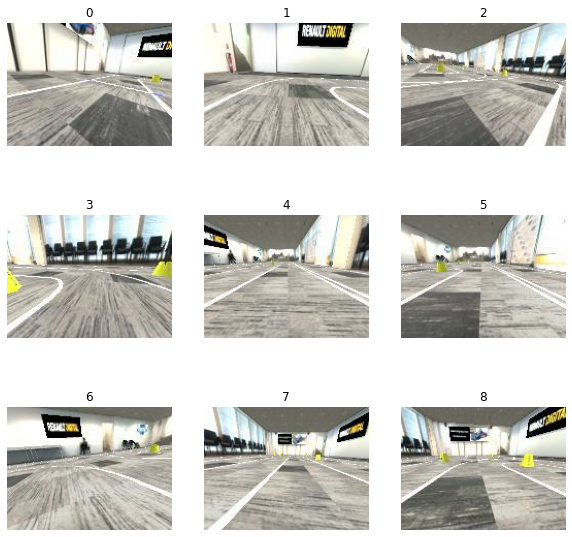

In [ ]:
plt.figure(figsize=(10, 10))
for i, img in enumerate(image_list_tf.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img.numpy().astype("uint8"))
  plt.title(str(i))
  plt.axis("off")

### Transformed images

In [ ]:
plt.figure(figsize=(20, 20))
for i, img in enumerate(transformed_image_list_tf.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img.numpy().astype("uint8"))
  plt.title(str(i))
  plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.